In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from tqdm import tqdm

if torch.cuda.is_available():
  device  = torch.device('cuda:0')
  print('GPU')
else:
  device  = torch.device('cpu')
  print('CPU')

SEED = 42

CPU


In [ ]:
# converts MNIST images to a 4D tensor[image_index, row, column, color]
transform = transforms.ToTensor()

# download MNIST data and convert to tensor
train_data = datasets.MNIST(root='/mnist', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='/mnist', train=False, download=True, transform=transform)

train_data, test_data


(Dataset MNIST
     Number of datapoints: 60000
     Root location: /mnist
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: /mnist
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [ ]:
# np.random.seed(SEED)
# create batch of images
train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=False)#, worker_init_fn=lambda id: np.random.seed(SEED))#, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=64, shuffle=False) # no need to shuffle test data


In [ ]:
class Model(nn.Module):
  def __init__(self, img_channel=1, img_height=28, img_width=28, layer1_kernels=8,
               layer2_kernels=16, hidden1=120, hidden2=84, output=10):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=img_channel, out_channels=layer1_kernels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels=layer1_kernels, out_channels=layer2_kernels, kernel_size=3, stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Flatten()
    )

    in_features = self.calc_flattened_input_dim(img_channel, img_height, img_width)

    self.fc = nn.Sequential(
        nn.Linear(in_features = in_features, out_features = hidden1, bias = True),
        nn.ReLU(),

        nn.Linear(in_features = hidden1, out_features = hidden2, bias = True),
        nn.ReLU(),

        nn.Linear(in_features = hidden2, out_features = output, bias = True)
        # we dont need a softmax layer as we are using cross entropy which
        # does softmax internally.
        # nn.Softmax()
    )

  def calc_flattened_input_dim(self, img_channel, img_height, img_width):
    x = torch.rand(1, img_channel, img_height, img_width)
    x = self.conv(x)
    return x.size(1)

  def forward(self, x):
    x = self.conv(x)
    return self.fc(x)

# class Model(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1)
#     self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1)
#     self.fc1 = nn.Linear(in_features = 5*5*16, out_features = 120, bias = True)
#     self.fc2 = nn.Linear(in_features = 120, out_features = 84, bias = True)
#     self.fc3 = nn.Linear(in_features = 84, out_features = 10, bias = True)


#   def forward(self, x):
#     x = F.relu(self.conv1(x))
#     x = F.max_pool2d(x, 2, 2)
#     x = F.relu(self.conv2(x))
#     x = F.max_pool2d(x, 2, 2)

#     #flatten
#     x = x.view(-1, 16*5*5)

#     x = F.relu(self.fc1(x))
#     x = F.relu(self.fc2(x))
#     x = self.fc3(x)

#     return F.log_softmax(x, dim=1)

In [ ]:
torch.manual_seed(SEED)

model = Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
import time
start_time = time.time()

training_loss_list = []
testing_loss_list = []

epochs = 7
for i in tqdm(range(epochs)):
  # set model to training mode. this is ensures that batch-norm and
  # drop-out behave accordingly during training
  model.train()
  # batch training
  for j, (X_train, y_train) in enumerate(train_loader):
    y_pred = model(X_train.to(device))
    batch_training_loss = criterion(y_pred, y_train.to(device))

    optimizer.zero_grad()
    batch_training_loss.backward()
    optimizer.step()

  # append loss from the last train batch for showing in plot
  training_loss_list.append(batch_training_loss.item())

  # swith to evaluation mode
  model.eval()
  number_of_correct_predictions = 0
  with torch.no_grad():
    for k, (X_test, y_test) in enumerate(test_loader):
      y_eval = model(X_test.to(device))
      _, eval = torch.max(y_eval, dim=1)
      number_of_correct_predictions += (eval == y_test.to(device)).sum()

  print(f'epoch: {i}: {number_of_correct_predictions} correct predictions in {len(test_data)} samples')

  # append loss from the last test batch for showing in plot
  batch_testing_loss = criterion(y_eval, y_test.to(device))
  testing_loss_list.append(batch_testing_loss.item())

end_time = time.time()
elapsed_time = end_time - start_time
print(f'elapsed time {elapsed_time/60} min')

 14%|█▍        | 1/7 [00:24<02:27, 24.60s/it]

epoch: 0: 9670 correct predictions in 10000 samples


 29%|██▊       | 2/7 [00:48<02:00, 24.15s/it]

epoch: 1: 9716 correct predictions in 10000 samples


 43%|████▎     | 3/7 [01:12<01:36, 24.22s/it]

epoch: 2: 9751 correct predictions in 10000 samples


 57%|█████▋    | 4/7 [01:37<01:13, 24.49s/it]

epoch: 3: 9764 correct predictions in 10000 samples


 71%|███████▏  | 5/7 [02:02<00:49, 24.59s/it]

epoch: 4: 9790 correct predictions in 10000 samples


 86%|████████▌ | 6/7 [02:27<00:24, 24.64s/it]

epoch: 5: 9805 correct predictions in 10000 samples


100%|██████████| 7/7 [02:51<00:00, 24.55s/it]

epoch: 6: 9837 correct predictions in 10000 samples
elapsed time 2.8644378662109373 min


[0.026306208223104477,
 0.001390226068906486,
 0.029515240341424942,
 0.018783604726195335,
 0.000217435896047391,
 5.081218205305049e-06,
 1.147384296018572e-06]

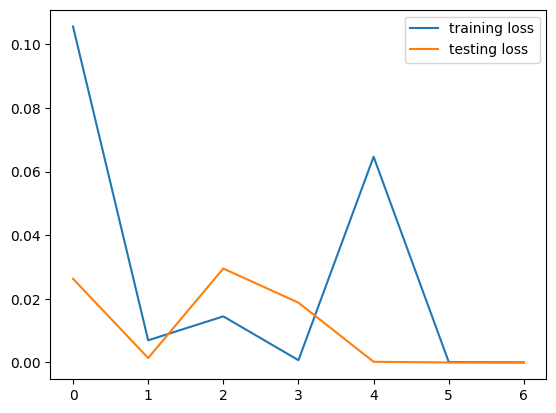

In [ ]:
plt.plot(training_loss_list, label = 'training loss')
plt.plot(testing_loss_list, label = 'testing loss')
plt.legend()

testing_loss_list

tensor([[ 22.6213, -16.3617,  -7.1605, -14.5811, -12.0349,  -1.5627,  -0.5338,
         -12.0844,  -9.3595,  -4.0352]]) tensor(0)


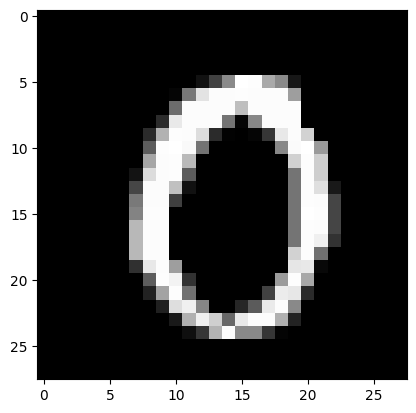

In [ ]:
TEST_IMG_NO = 13
plt.imshow(test_data[TEST_IMG_NO][0].view(28, 28), cmap='gray')

model.eval()
with torch.no_grad():
  test_pred = model(test_data[TEST_IMG_NO][0].view(1, 1, 28, 28).to(device)) # [batch size, color channel, row, col ]
  print(test_pred, test_pred.argmax())